In [2]:
# Import from Standard Library
import logging
import os
import pathlib
import subprocess
import warnings
from glob import glob

# Import from Third Party Libraries
import earthpy.appeears as etapp
import folium
import geopandas as gpd
import hvplot.pandas
import hvplot.xarray
import pandas as pd
import rioxarray as rxr
import xarray as xr


# Set up logging so AppeearsDownloader will log in notebook
logging.basicConfig(level=logging.INFO)

# Ignore FutureWarning coming from hvplot
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Define File Path For Data
boston_path = os.path.join(pathlib.Path.home(),
                             'earth-analytics', 'data', 'boston_green')

# Create Directory Using Path
os.makedirs(boston_path, exist_ok=True)

boston_path

'/home/jovyan/earth-analytics/data/boston_green'

In [4]:
boston_bnd_gdf = gpd.read_file(
    "https://gis.boston.gov/arcgis/rest/services/Planning/OpenData/"
    "MapServer/9/query?where=1%3D1&outFields=*&outSR=4326&f=json")

boston_bnd_gdf

OBJECTID  BOSTON_LAN CITY COUNTY  SHAPE.STArea()  SHAPE.STLength()  \
0         1         1.0                1.346516e+09     816364.595339   

                                            geometry  
0  MULTIPOLYGON (((-71.19083 42.28332, -71.17871 ...

In [5]:
# Define Paradise, CA Location
boston_lat = 42.3601
boston_lon = -71.0589

# Create Map
m = folium.Map(location=(boston_lat-.045, boston_lon), 
               tiles=None,
               zoom_start=11)

# Convert data to JSON
boston_bnd_json = boston_bnd_gdf.to_json()

# Add fire boundary to map
folium.GeoJson(boston_bnd_json).add_to(m)

# Add approximate starting location
folium.Marker(location=[boston_lat, boston_lon],
      popup="Boston, MA"
      ).add_to(m)

# Add ESRI World Imagery (Source: https://gis.stackexchange.com/
# questions/290861/python-folium-package-for-satellite-map)
tile = folium.TileLayer(
        tiles = ('https://server.arcgisonline.com/ArcGIS/rest/services/'
        'World_Imagery/MapServer/tile/{z}/{y}/{x}'),
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = False,
        control = True
       ).add_to(m)

m


&#9998; In the cell below, write a description of the data you will use. Make sure to include:
  * A citation
  * A brief explanation of the platform (Aqua satellite), sensor (MODIS), and post-processing (NDVI), including why these data will help you see vegetation recovery after a wildfire


WRITE YOUR DATA DESCRIPTION AND CITATION HERE

In [6]:
# Initialize AppeearsDownloader for MODIS NDVI data
ndvi_downloader = etapp.AppeearsDownloader(
    download_key="modis-ndvi",
    ea_dir=boston_path,
    product="MYD13Q1.061",
    layer="_250m_16_days_NDVI",
    start_date="06-01",
    end_date="08-31",
    recurring=True,
    year_range=[2013, 2023],
    polygon=boston_bnd_gdf,
)

# Download files if the download directory does not exist
if not os.path.exists(ndvi_downloader.data_dir):
    ndvi_downloader.download_files()

ndvi_downloader

In [7]:
# Print all dirs found by glob
data_dirs = os.path.join(boston_path, "*")
all_dirs = glob(data_dirs)
# Nesting for loops
boston_files = []
for a_dir in all_dirs:
    dir_path = os.path.join(a_dir, "*")
    all_file_paths = (glob(dir_path))
    # Create a nested loop which loops through each directory
    for a_file_path in all_file_paths:
       boston_files.append(a_file_path)
boston_files_sort = sorted(boston_files)
boston_files_sort

glob(ndvi_downloader.data_dir)

['/home/jovyan/earth-analytics/data/boston_green/modis-ndvi']

In [8]:
# Create List of NDVI tif files
ndvi_path_lst = glob(os.path.join(ndvi_downloader.data_dir, "*", "*NDVI*.tif"))

ndvi_path_lst

['/home/jovyan/earth-analytics/data/boston_green/modis-ndvi/MYD13Q1.061_2013137_to_2023243/MYD13Q1.061__250m_16_days_NDVI_doy2015185_aid0001.tif',
 '/home/jovyan/earth-analytics/data/boston_green/modis-ndvi/MYD13Q1.061_2013137_to_2023243/MYD13Q1.061__250m_16_days_NDVI_doy2014233_aid0001.tif',
 '/home/jovyan/earth-analytics/data/boston_green/modis-ndvi/MYD13Q1.061_2013137_to_2023243/MYD13Q1.061__250m_16_days_NDVI_doy2016153_aid0001.tif',
 '/home/jovyan/earth-analytics/data/boston_green/modis-ndvi/MYD13Q1.061_2013137_to_2023243/MYD13Q1.061__250m_16_days_NDVI_doy2013169_aid0001.tif',
 '/home/jovyan/earth-analytics/data/boston_green/modis-ndvi/MYD13Q1.061_2013137_to_2023243/MYD13Q1.061__250m_16_days_NDVI_doy2020201_aid0001.tif',
 '/home/jovyan/earth-analytics/data/boston_green/modis-ndvi/MYD13Q1.061_2013137_to_2023243/MYD13Q1.061__250m_16_days_NDVI_doy2023233_aid0001.tif',
 '/home/jovyan/earth-analytics/data/boston_green/modis-ndvi/MYD13Q1.061_2013137_to_2023243/MYD13Q1.061__250m_16_days_N

In [9]:
doy_start = -19
doy_end = -12
scale_factor = 10000
ndvi_da_list = []
for ndvi_path in ndvi_path_lst:
    # Get date from file name
    doy = ndvi_path[doy_start:doy_end]
    date = pd.to_datetime(doy, format='%Y%j')
    # Open dataset
    da = rxr.open_rasterio(ndvi_path, masked=True).squeeze()

    # Prepare to concatenate: Add date dimension and clean up metadata
    da = da.assign_coords({'date': date})
    da = da.expand_dims({'date': 1})
    da.name = 'NDVI'

    # Divide by scale factor
    da = da / scale_factor
    # Add the DataArray to the end of the accumulator list
    ndvi_da_list.append(da)
ndvi_da_list

[<xarray.DataArray 'NDVI' (date: 1, y: 82, x: 129)>
 array([[[0.7579, 0.7972, 0.8133, ...,    nan,    nan,    nan],
         [0.6585, 0.7297, 0.8263, ...,    nan,    nan,    nan],
         [0.6875, 0.7537, 0.7537, ...,    nan,    nan,    nan],
         ...,
         [0.7609, 0.7609, 0.5677, ..., 0.7654, 0.626 , 0.6547],
         [0.7899, 0.7333, 0.4383, ..., 0.7607, 0.6547, 0.6547],
         [0.8192, 0.7397, 0.6762, ..., 0.8119, 0.8119, 0.789 ]]],
       dtype=float32)
 Coordinates:
     band         int64 1
   * x            (x) float64 -71.19 -71.19 -71.19 ... -70.93 -70.93 -70.92
   * y            (y) float64 42.4 42.39 42.39 42.39 ... 42.23 42.23 42.23 42.23
     spatial_ref  int64 0
   * date         (date) datetime64[ns] 2015-07-04,
 <xarray.DataArray 'NDVI' (date: 1, y: 82, x: 129)>
 array([[[0.8063, 0.8063, 0.8412, ...,    nan,    nan,    nan],
         [0.8177, 0.8177, 0.8177, ...,    nan,    nan,    nan],
         [0.7349, 0.8177, 0.8177, ...,    nan,    nan,    nan],
       

In [10]:
ndvi_ds = xr.combine_by_coords(ndvi_da_list, coords=['date'])

ndvi_ds

<xarray.Dataset>
Dimensions:      (x: 129, y: 82, date: 75)
Coordinates:
    band         int64 1
  * x            (x) float64 -71.19 -71.19 -71.19 ... -70.93 -70.93 -70.92
  * y            (y) float64 42.4 42.39 42.39 42.39 ... 42.23 42.23 42.23 42.23
    spatial_ref  int64 0
  * date         (date) datetime64[ns] 2013-05-17 2013-06-02 ... 2023-08-21
Data variables:
    NDVI         (date, y, x) float32 0.7526 0.7526 0.7572 ... 0.7482 0.728

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

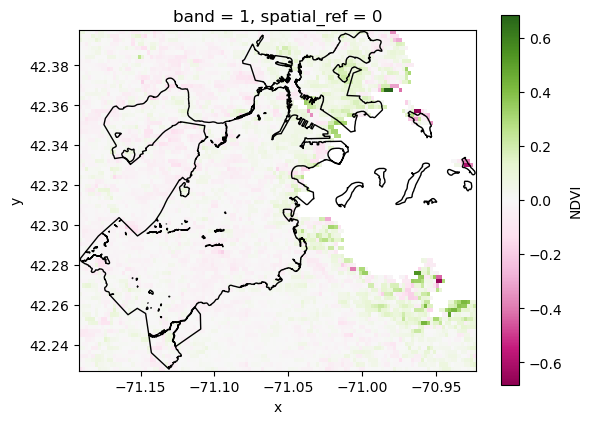

In [11]:
# Import pyplot from matplotlib
import matplotlib.pyplot as plt

# Get mean NDVI data for 2023
ndvi_2023_da = (ndvi_ds
    .sel(date='2023')
    .mean('date')
    .NDVI
)

# Get mean NDVI data for 2019
ndvi_2013_da = (ndvi_ds
    .sel(date='2013')
    .mean('date')
    .NDVI
)

# Get difference between 2023 and 2019
ndvi_diff_da = ndvi_2023_da - ndvi_2013_da

# Plot difference in NDVI data
ndvi_diff_da.plot(cmap=plt.colormaps['PiYG'])

# Add Campfire boundary
boston_bnd_gdf.plot(ax=plt.gca(), facecolor='none')

In [12]:
# Get area outside of Rim Fire
out_gdf = (
    gpd.GeoDataFrame(geometry=boston_bnd_gdf.envelope)
    .overlay(right=boston_bnd_gdf, how="difference")
)

out_gdf

geometry
0  MULTIPOLYGON (((-71.19084 42.28319, -71.19084 ...

In [13]:
# Clip Boston data to boundary
ndvi_boston_ds = ndvi_ds.rio.clip(boston_bnd_gdf.geometry)

# Clip area outside of Boston
ndvi_out_ds = ndvi_ds.rio.clip(out_gdf.geometry)

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

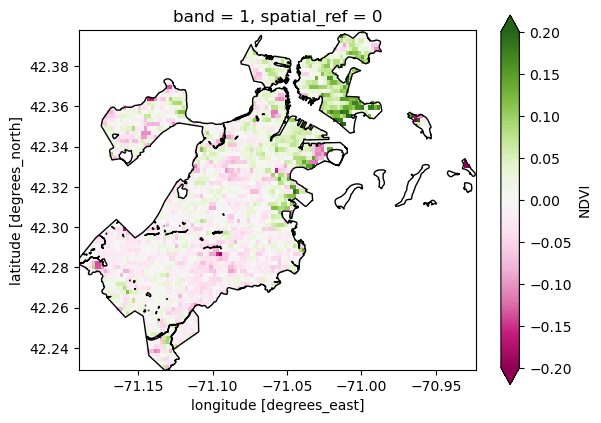

In [14]:
# Import pyplot from matplotlib
import matplotlib.pyplot as plt

# Get mean NDVI data for 2023
ndvi_boston_2023_da = (ndvi_boston_ds
    .sel(date='2023')
    .mean('date')
    .NDVI
)

# Get mean NDVI data for 2019
ndvi_boston_2013_da = (ndvi_boston_ds
    .sel(date='2013')
    .mean('date')
    .NDVI
)

# Get difference between 2023 and 2019
ndvi_boston_diff_da = ndvi_boston_2023_da - ndvi_boston_2013_da

# Plot difference in NDVI data
ndvi_boston_diff_da.plot(cmap=plt.colormaps['PiYG'], vmin=-.2, vmax=.2)

# Add Campfire boundary
boston_bnd_gdf.plot(ax=plt.gca(), facecolor='none')

In [15]:
# Define function to get dataframe of mean NDVI by year
def df_annual_ndvi(indata):
    return (
        indata.groupby(indata.date.dt.year)
        .mean(...)
        .NDVI.to_dataframe()[["NDVI"]]
    )

# Create dataframe of NDVI for Campfire area
ndvi_boston_df = df_annual_ndvi(ndvi_boston_ds)

# Create dataframe of NDVI for the area outside Campire
ndvi_out_df = df_annual_ndvi(ndvi_out_ds)

# Check value
print(round((ndvi_boston_df - ndvi_out_df).sum(), 2).sum())

# Return dataframes
ndvi_boston_df, ndvi_out_df

-0.82


(          NDVI
 year          
 2013  0.503524
 2014  0.500207
 2015  0.489067
 2016  0.464942
 2017  0.483939
 2018  0.487592
 2019  0.498711
 2020  0.475405
 2021  0.486038
 2022  0.477846
 2023  0.504517,
           NDVI
 year          
 2013  0.571802
 2014  0.572210
 2015  0.560757
 2016  0.543170
 2017  0.558995
 2018  0.564034
 2019  0.572602
 2020  0.558681
 2021  0.558728
 2022  0.552229
 2023  0.574236)

<Axes: title={'center': 'Difference between Summer NDVI inside and outside Rim Fire area '}, xlabel='Year', ylabel='Summer NDVI'>

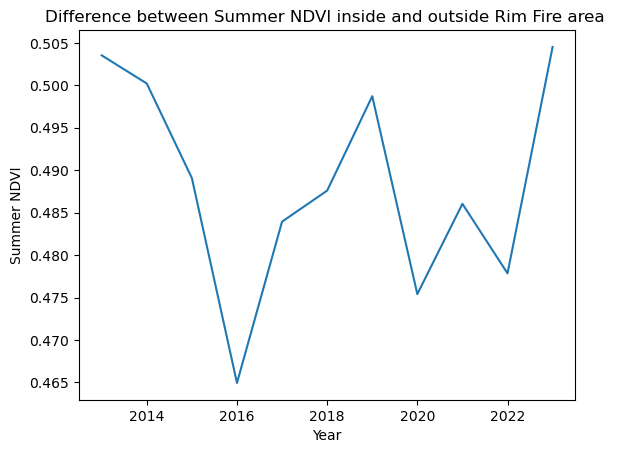

In [16]:
# Calculate Difference between Dataframes & Save to Dataframe
ndvi_boston_df['Difference'] = (ndvi_boston_df - ndvi_out_df)

# Plot Difference
ndvi_boston_df.NDVI.plot(
    title="Difference between Summer NDVI inside and outside Rim Fire area ",
    xlabel="Year",
    ylabel="Summer NDVI")

# # Trying to add vertical line
# import datetime

# camp_date= datetime.datetime(2018, 11, 8)

# # Start of Year in Ordinal Format
# start_date = datetime.datetime(2018, 1, 1).toordinal()

# # Length of Year
# year_len = datetime.date(2019, 1, 1).toordinal() - start_date

# # Camp Fire Date in Ordinal Format
# camp_date_ord = camp_date.year + (camp_date.toordinal() - start_date) / year_len
# camp_date_ord

# # Plot with vertical line
# plt.plot(ndvi_fire_df.reset_index()["year"], ndvi_fire_df["Difference"])
# plt.axvline(x=camp_date_ord, color='red', ls='--')
# plt.show()

### NDVI within the fire boundary has increased since the fire. However, it is yet to reach pre-fire levels ten years later.


# Boston-Cambridge-Newton CBSA Area

In [17]:
# Define File Path For Data
boston_cbsa_path = os.path.join(pathlib.Path.home(),
                             'earth-analytics', 'data', 'boston_cbsa_green')

# Create Directory Using Path
os.makedirs(boston_cbsa_path, exist_ok=True)

boston_cbsa_path

'/home/jovyan/earth-analytics/data/boston_cbsa_green'

In [18]:
boston_cbsa_bnd_gdf = gpd.read_file(
    "https://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/"
    "usa_cbsa/FeatureServer/0/query"
    "?where=CBSA_ID%20%3D%20'14460'"
    "&outFields=*&outSR=4326&f=json")

boston_cbsa_bnd_gdf

FID  OBJECTID CBSA_ID                            NAME     CBSA_TYPE  \
0  105       105   14460  Boston-Cambridge-Newton, MA-NH  Metropolitan   

   POPULATION  POP_SQMI  POP2010  POP10_SQMI    WHITE  ...  HSE_UNITS  VACANT  \
0     4866556   1345.33  4552402      1247.0  3587540  ...    1883206  122622   

   OWNER_OCC  RENTER_OCC     SQMI  Shape_Leng  Shape_Area   Shape__Area  \
0    1082688      677896  3617.37   20.192567    1.027043  1.727979e+10   

   Shape__Length                                           geometry  
0   2.594595e+06  MULTIPOLYGON (((-70.80332 41.61816, -70.80282 ...  

[1 rows x 54 columns]

In [19]:
# Define Boston Location
boston_lat = 42.3601
boston_lon = -71.0589

# Create Map
m = folium.Map(location=(boston_lat+.2, boston_lon), 
               tiles=None,
               zoom_start=8)

# Convert data to JSON
boston_cbsa_bnd_json = boston_cbsa_bnd_gdf.to_json()

# Add fire boundary to map
folium.GeoJson(boston_cbsa_bnd_json).add_to(m)

# Add approximate starting location
folium.Marker(location=[boston_lat, boston_lon],
      popup="Boston, MA"
      ).add_to(m)

# Add ESRI World Imagery (Source: https://gis.stackexchange.com/
# questions/290861/python-folium-package-for-satellite-map)
tile = folium.TileLayer(
        tiles = ('https://server.arcgisonline.com/ArcGIS/rest/services/'
        'World_Imagery/MapServer/tile/{z}/{y}/{x}'),
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = False,
        control = True
       ).add_to(m)

m


In [20]:
# Initialize AppeearsDownloader for MODIS NDVI data
ndvi_downloader = etapp.AppeearsDownloader(
    download_key="modis-ndvi",
    ea_dir=boston_cbsa_path,
    product="MYD13Q1.061",
    layer="_250m_16_days_NDVI",
    start_date="06-01",
    end_date="08-31",
    recurring=True,
    year_range=[2013, 2023],
    polygon=boston_cbsa_bnd_gdf,
)

# Download files if the download directory does not exist
if not os.path.exists(ndvi_downloader.data_dir):
    ndvi_downloader.download_files()

ndvi_downloader

In [21]:
# Print all dirs found by glob
data_dirs = os.path.join(boston_cbsa_path, "*")
all_dirs = glob(data_dirs)
# Nesting for loops
boston_cbsa_files = []
for a_dir in all_dirs:
    dir_path = os.path.join(a_dir, "*")
    all_file_paths = (glob(dir_path))
    # Create a nested loop which loops through each directory
    for a_file_path in all_file_paths:
       boston_cbsa_files.append(a_file_path)
boston_cbsa_files_sort = sorted(boston_cbsa_files)
boston_cbsa_files_sort

glob(ndvi_downloader.data_dir)

['/home/jovyan/earth-analytics/data/boston_cbsa_green/modis-ndvi']

In [22]:
# Create List of NDVI tif files
ndvi__cbsa_path_lst = glob(os.path.join(ndvi_downloader.data_dir, "*", "*NDVI*.tif"))

ndvi__cbsa_path_lst

['/home/jovyan/earth-analytics/data/boston_cbsa_green/modis-ndvi/MYD13Q1.061_2013137_to_2023243/MYD13Q1.061__250m_16_days_NDVI_doy2015185_aid0001.tif',
 '/home/jovyan/earth-analytics/data/boston_cbsa_green/modis-ndvi/MYD13Q1.061_2013137_to_2023243/MYD13Q1.061__250m_16_days_NDVI_doy2014233_aid0001.tif',
 '/home/jovyan/earth-analytics/data/boston_cbsa_green/modis-ndvi/MYD13Q1.061_2013137_to_2023243/MYD13Q1.061__250m_16_days_NDVI_doy2016153_aid0001.tif',
 '/home/jovyan/earth-analytics/data/boston_cbsa_green/modis-ndvi/MYD13Q1.061_2013137_to_2023243/MYD13Q1.061__250m_16_days_NDVI_doy2013169_aid0001.tif',
 '/home/jovyan/earth-analytics/data/boston_cbsa_green/modis-ndvi/MYD13Q1.061_2013137_to_2023243/MYD13Q1.061__250m_16_days_NDVI_doy2020201_aid0001.tif',
 '/home/jovyan/earth-analytics/data/boston_cbsa_green/modis-ndvi/MYD13Q1.061_2013137_to_2023243/MYD13Q1.061__250m_16_days_NDVI_doy2023233_aid0001.tif',
 '/home/jovyan/earth-analytics/data/boston_cbsa_green/modis-ndvi/MYD13Q1.061_2013137_to_

In [23]:
doy_start = -19
doy_end = -12
scale_factor = 10000
ndvi_cbsa_da_list = []
for ndvi_path in ndvi__cbsa_path_lst:
    # Get date from file name
    doy = ndvi_path[doy_start:doy_end]
    date = pd.to_datetime(doy, format='%Y%j')
    # Open dataset
    da = rxr.open_rasterio(ndvi_path, masked=True).squeeze()

    # Prepare to concatenate: Add date dimension and clean up metadata
    da = da.assign_coords({'date': date})
    da = da.expand_dims({'date': 1})
    da.name = 'NDVI'

    # Divide by scale factor
    da = da / scale_factor
    # Add the DataArray to the end of the accumulator list
    ndvi_cbsa_da_list.append(da)
ndvi_cbsa_da_list

[<xarray.DataArray 'NDVI' (date: 1, y: 939, x: 660)>
 array([[[0.895 , 0.895 , 0.895 , ..., 0.8658, 0.8658, 0.8654],
         [0.8873, 0.8873, 0.8175, ..., 0.8658, 0.8658, 0.8654],
         [0.889 , 0.8403, 0.8403, ..., 0.8407, 0.8407, 0.8407],
         ...,
         [0.9322, 0.9322, 0.9307, ..., 0.7999, 0.8371, 0.8371],
         [0.9348, 0.9263, 0.9263, ..., 0.7043, 0.781 , 0.781 ],
         [0.9348, 0.9279, 0.9279, ..., 0.7917, 0.7917, 0.8547]]],
       dtype=float32)
 Coordinates:
     band         int64 1
   * x            (x) float64 -71.9 -71.9 -71.89 -71.89 ... -70.53 -70.53 -70.53
   * y            (y) float64 43.57 43.57 43.57 43.57 ... 41.62 41.62 41.62 41.62
     spatial_ref  int64 0
   * date         (date) datetime64[ns] 2015-07-04,
 <xarray.DataArray 'NDVI' (date: 1, y: 939, x: 660)>
 array([[[0.9003, 0.9003, 0.8754, ..., 0.884 , 0.884 , 0.8696],
         [0.8657, 0.8657, 0.8657, ..., 0.8929, 0.8929, 0.8839],
         [0.8657, 0.884 , 0.884 , ..., 0.8795, 0.8853, 0.8853],

In [24]:
ndvi_cbsa_ds = xr.combine_by_coords(ndvi_cbsa_da_list, coords=['date'])

ndvi_cbsa_ds

<xarray.Dataset>
Dimensions:      (x: 660, y: 939, date: 75)
Coordinates:
    band         int64 1
  * x            (x) float64 -71.9 -71.9 -71.89 -71.89 ... -70.53 -70.53 -70.53
  * y            (y) float64 43.57 43.57 43.57 43.57 ... 41.62 41.62 41.62 41.62
    spatial_ref  int64 0
  * date         (date) datetime64[ns] 2013-05-17 2013-06-02 ... 2023-08-21
Data variables:
    NDVI         (date, y, x) float32 0.7842 0.7842 0.7842 ... 0.7837 0.6832

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

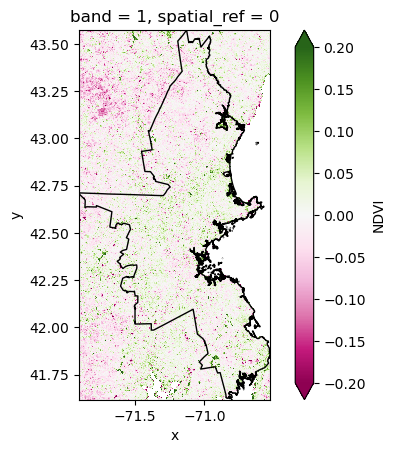

In [41]:
# Get mean NDVI data for 2023
ndvi_cbsa_2023_da = (ndvi_cbsa_ds
    .sel(date='2023')
    .mean('date')
    .NDVI
)

# Get mean NDVI data for 2019
ndvi_cbsa_2013_da = (ndvi_cbsa_ds
    .sel(date='2013')
    .mean('date')
    .NDVI
)

# Get difference between 2023 and 2019
ndvi_cbsa_diff_da = ndvi_cbsa_2023_da - ndvi_cbsa_2013_da

# Plot difference in NDVI data
ndvi_cbsa_diff_da.plot(cmap=plt.colormaps['PiYG'], vmin=-.2, vmax=.2)

# # Add Campfire boundary
boston_cbsa_bnd_gdf.plot(ax=plt.gca(), facecolor='none')

In [26]:
# Get area outside of Rim Fire
out_cbsa_gdf = (
    gpd.GeoDataFrame(geometry=boston_cbsa_bnd_gdf.envelope)
    .overlay(right=boston_cbsa_bnd_gdf, how="difference")
)

out_cbsa_gdf

geometry
0  MULTIPOLYGON (((-71.89877 41.61702, -71.89877 ...

In [27]:
# Clip Boston data to boundary
ndvi_boston_cbsa_ds = ndvi_cbsa_ds.rio.clip(boston_cbsa_bnd_gdf.geometry)

# # Clip area outside of Boston
# ndvi_out_cbsa_ds = ndvi_cbsa_ds.rio.clip(out_cbsa_gdf.geometry)

In [30]:
# Define function to get dataframe of mean NDVI by year
# Create dataframe of NDVI for Campfire area
ndvi_boston_cbsa_df = df_annual_ndvi(ndvi_boston_cbsa_ds)

# Return dataframes
ndvi_boston_cbsa_df

NDVI
year          
2013  0.772711
2014  0.770890
2015  0.770287
2016  0.761667
2017  0.760520
2018  0.777606
2019  0.773071
2020  0.771235
2021  0.769267
2022  0.772543
2023  0.775022

<Axes: title={'center': 'Difference between Summer NDVI inside and outside Rim Fire area '}, xlabel='Year', ylabel='Summer NDVI'>

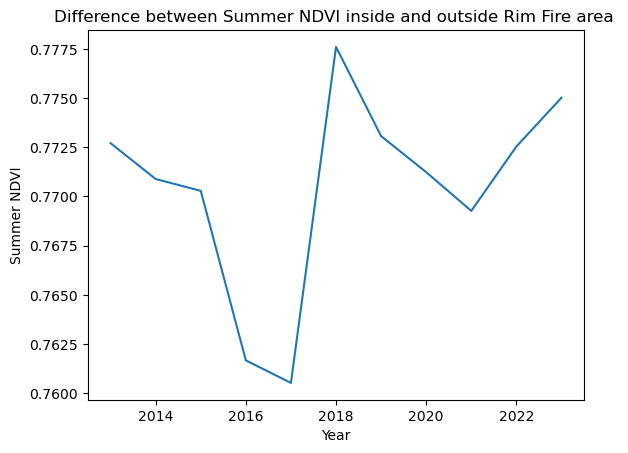

In [31]:

# Plot Difference
ndvi_boston_cbsa_df.NDVI.plot(
    title="Difference between Summer NDVI inside and outside Rim Fire area ",
    xlabel="Year",
    ylabel="Summer NDVI")